In [1]:
# Configuracion
import os
import multiprocessing

os.environ["LOKY_MAX_CPU_COUNT"] = str(multiprocessing.cpu_count())

# Librarias principales
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Guardado de modelos
from pathlib import Path
import joblib

# Agregar el directorio src al path
import sys
sys.path.append('../../src')


from visualization import graficar_roc_auc, graficar_confusion_matrix

<b> Ahora Se va empezar lo entrenamiento de los modelos. Es importante que en nuestro pipeline de entrenamiento Se necesita de un balancing </b>
- Voy hacer o balancing por SMOTE+Undersample listo que Se tienen muchas lineas, si no va a ser un entrenamiento super grande.
- Se va empezar con modelos simples Logistic Regression and Simple decision tree y tambien usando solo las variables que Se tienen al principio sin la Feature enginnering
- Se va crear un standardized para logistic y un no standardized para decision tree
- Despues intentaremos ensemble mejores y por fin con lo mejor modelo voy aplicar Optuna

In [2]:
df_devices = pd.read_parquet('../../data/01_processed/full_devices.parquet')

In [3]:
df_devices.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'attribute1_diff1', 'attribute1_roll_mean3', 'attribute2_diff1',
       'attribute3_diff1', 'attribute4_diff1', 'attribute5_diff1',
       'attribute6_diff1', 'attribute7_diff1', 'attribute7_roll_mean3',
       'attribute9_diff1'],
      dtype='object')

In [4]:
# df = pd.read_csv("tu_dataset.csv")
X = df_devices.drop(columns=['date', 'device', 'failure'])
y = df_devices['failure']

# Dividir en train y test ANTES de hacer el balanceo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Definir el pipeline: primero SMOTE (oversampling), luego undersampling
over = SMOTE(sampling_strategy=0.1, random_state=42)   # Aumenta la clase minoritaria hasta el 10% de la mayoritaria
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Reduce la mayoritaria hasta un balance 50:50
steps = [('o', over), ('u', under)]
resample_pipeline = Pipeline(steps=steps)

In [5]:
# Aplicar el balanceo solo al conjunto de entrenamiento
X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)

PROD = Path("../../production")
( PROD / "pipeline" ).mkdir(parents=True, exist_ok=True)

joblib.dump(X_train_res, PROD / "pipeline" / "X_train.joblib")
joblib.dump(y_train_res, PROD / "pipeline" / "y_train.joblib")
joblib.dump(X_test,      PROD / "pipeline" / "X_test.joblib")
joblib.dump(y_test,      PROD / "pipeline" / "y_test.joblib")

print("Antes del balanceo:", y_train.value_counts())
print("Después del balanceo:", y_train_res.value_counts())

Antes del balanceo: failure
0    99510
1       85
Name: count, dtype: int64
Después del balanceo: failure
0    19902
1     9951
Name: count, dtype: int64


  File "c:\Users\leand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\leand\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leand\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\leand\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Regression Logistica

In [6]:
# Crear el pipeline: estandarización + regresión logística
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandariza las variables
    ('logreg', LogisticRegression(
        class_weight='balanced',    # Manejo de desbalance adicional
        max_iter=1000,              # Aumenta iteraciones por convergencia
        random_state=42
    ))
])

In [7]:
# Entrenar con el dataset balanceado
logreg_pipeline.fit(X_train_res, y_train_res)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [8]:
y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

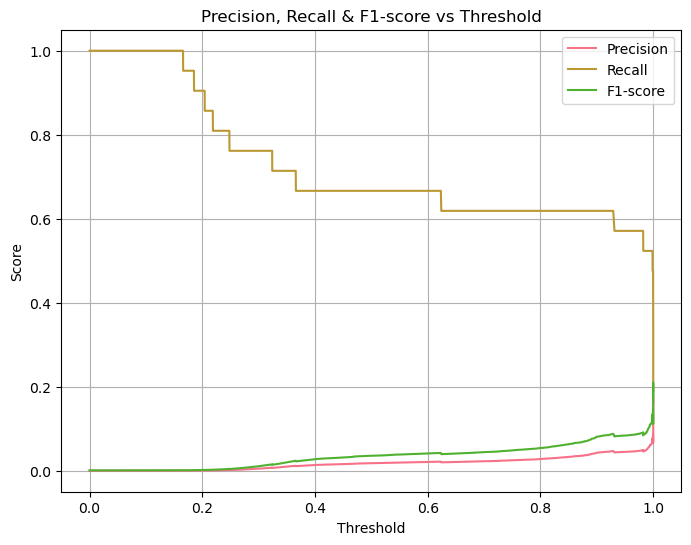

In [9]:
# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute F1 for each threshold
f1_scores = []
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

# Plot curves
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall & F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


<b> En 0.3 Se tienen un bueño gaño de recall de 10% encuanto solamente perdemos cerca de 10% en to True Negative </b>

In [10]:
# Predecir sobre el conjunto de prueba original (desbalanceado)
threshold = 0.3
y_train_pred = (logreg_pipeline.predict_proba(X_train_res)[:, 1] >= threshold).astype(int)
y_test_pred = (logreg_pipeline.predict_proba(X_test)[:, 1] >= threshold).astype(int)

In [11]:
# Métricas de evaluación
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      0.928     0.891     0.909     19902
           1      0.798     0.862     0.829      9951

    accuracy                          0.881     29853
   macro avg      0.863     0.876     0.869     29853
weighted avg      0.885     0.881     0.882     29853



In [12]:
# Métricas de evaluación
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.890     0.942     24878
           1      0.006     0.762     0.012        21

    accuracy                          0.890     24899
   macro avg      0.503     0.826     0.477     24899
weighted avg      0.999     0.890     0.941     24899



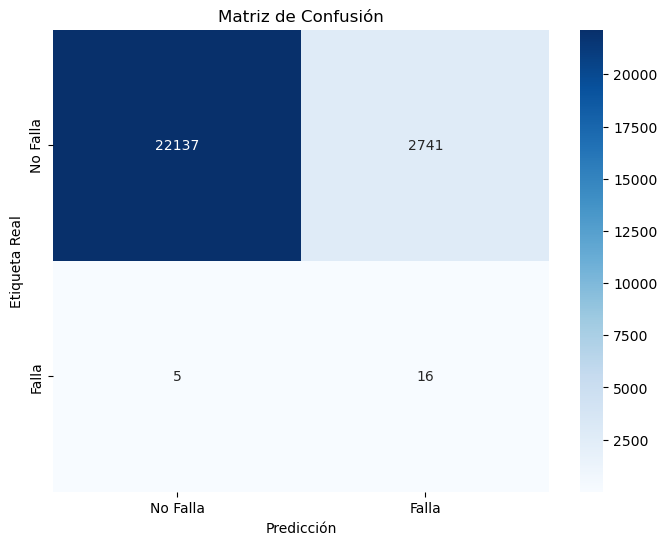

array([[22137,  2741],
       [    5,    16]], dtype=int64)

In [13]:
graficar_confusion_matrix(y_test, y_test_pred)

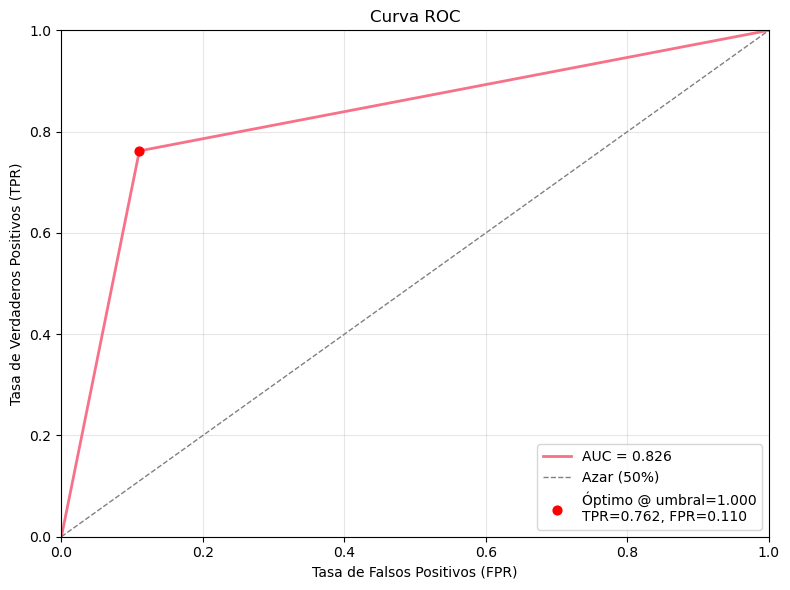

{'AUC': 0.8258635474448642,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.7619047619047619,
 'FPR óptimo': 0.11017766701503336}

In [14]:
graficar_roc_auc(y_test, y_test_pred)

In [15]:
# Save the model
joblib.dump(logreg_pipeline, "../../production/model/best_model_fe.pkl")

['../../production/model/best_model_fe.pkl']

<b> Acá esta mucho mejor, aun vemos un signal de overfitting porque nuestro entrenamiento está con 100% pero sigues mejor </b>
- Con la optimizacion de threshold llegamos a un TPR de 0.76 y a un TNR de 0.9 que para un baseline y primera implementacion esta perfecto.

# Arbore de decision

In [16]:
# Pipeline: solo el clasificador (no requiere escalado)
tree_pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(
        class_weight='balanced',   # Ajusta pesos para clases desbalanceadas
        max_depth=None,            # Sin límite inicial (puedes ajustar)
        random_state=42
    ))
])

In [17]:
# Entrenar con el dataset balanceado
tree_pipeline.fit(X_train_res, y_train_res)

Pipeline(steps=[('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [18]:
# Predecir sobre el conjunto de prueba original (desbalanceado)
threshold = 0.5
y_train_pred = (tree_pipeline.predict_proba(X_train_res)[:, 1] >= threshold).astype(int)
y_test_pred = (tree_pipeline.predict_proba(X_test)[:, 1] >= threshold).astype(int)

In [19]:
# Métricas de evaluación
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     19902
           1      1.000     1.000     1.000      9951

    accuracy                          1.000     29853
   macro avg      1.000     1.000     1.000     29853
weighted avg      1.000     1.000     1.000     29853



In [20]:
# Métricas de evaluación
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.991     0.995     24878
           1      0.013     0.143     0.024        21

    accuracy                          0.990     24899
   macro avg      0.506     0.567     0.510     24899
weighted avg      0.998     0.990     0.994     24899



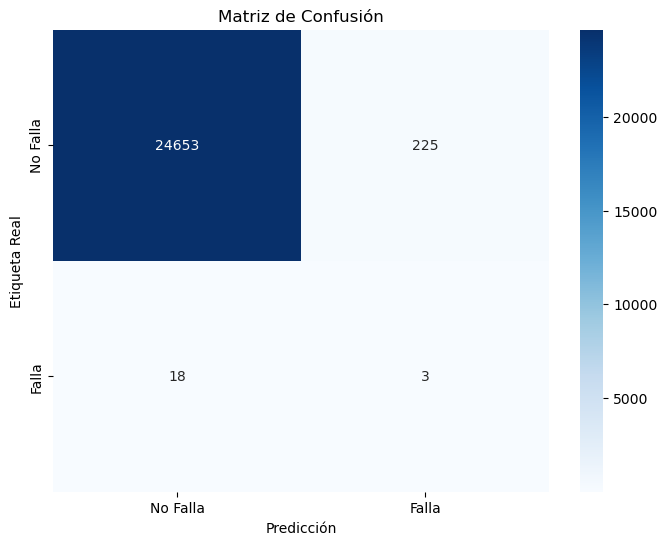

array([[24653,   225],
       [   18,     3]], dtype=int64)

In [21]:
graficar_confusion_matrix(y_test, y_test_pred)

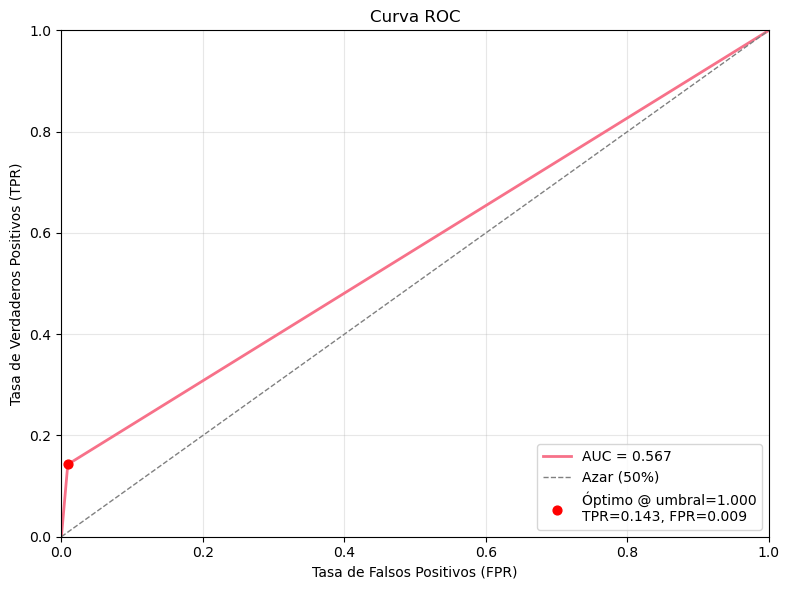

{'AUC': 0.5669065037382426,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.14285714285714285,
 'FPR óptimo': 0.00904413538065761}

In [22]:
graficar_roc_auc(y_test, y_test_pred)

<b> Sigue sin ningun tipo de otimizacion de hyperparametros </b>
- Antes de intentar mejorar con otimizacion de hyperparametros Se va intentar un ensemble model como xgboost, despues pasamos a correr un optuna sin feature engineering

# XGBoost

In [23]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200
)

In [24]:
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
threshold = 0.5
y_train_pred = (xgb_model.predict_proba(X_train_res)[:, 1] >= threshold).astype(int)
y_test_pred = (xgb_model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

In [26]:
# Métricas
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     19902
           1      1.000     1.000     1.000      9951

    accuracy                          1.000     29853
   macro avg      1.000     1.000     1.000     29853
weighted avg      1.000     1.000     1.000     29853



In [27]:
# Métricas
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.996     0.998     24878
           1      0.071     0.333     0.118        21

    accuracy                          0.996     24899
   macro avg      0.535     0.665     0.558     24899
weighted avg      0.999     0.996     0.997     24899



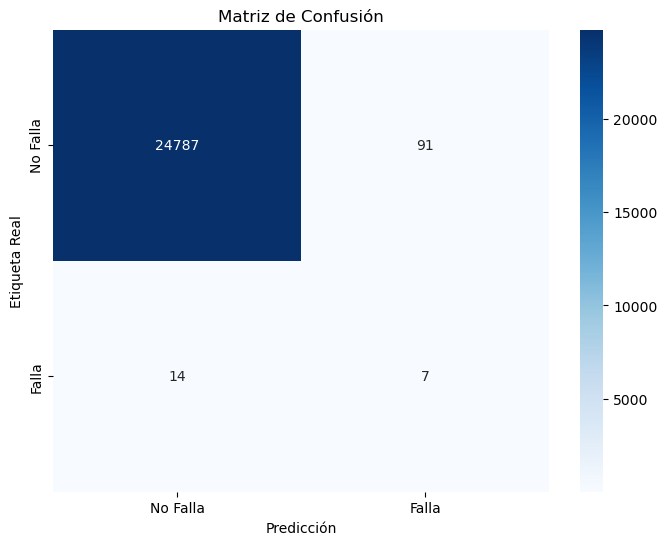

array([[24787,    91],
       [   14,     7]], dtype=int64)

In [28]:
graficar_confusion_matrix(y_test, y_test_pred)

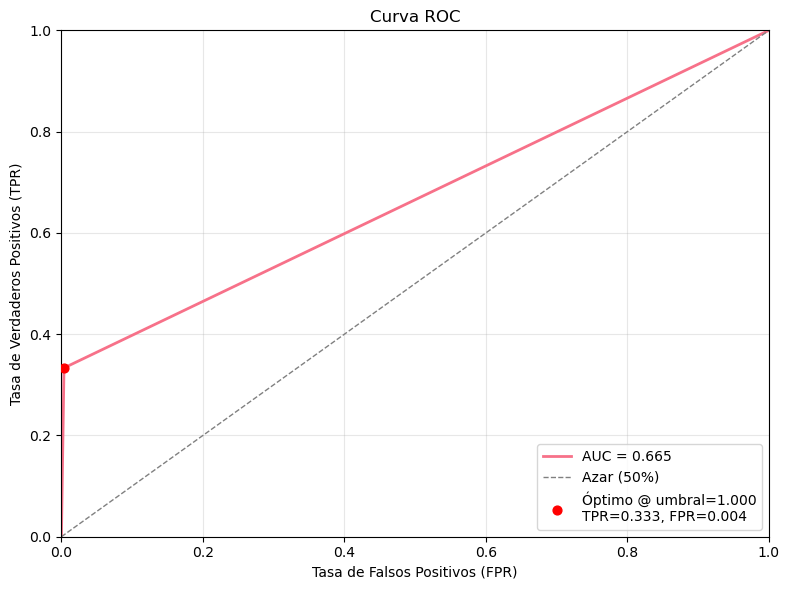

{'AUC': 0.6648377415119114,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.3333333333333333,
 'FPR óptimo': 0.0036578503095104106}

In [29]:
graficar_roc_auc(y_test, y_test_pred)

<b> XGboost </b> Demonstra de nuevo ser un poquito mejor que una arbore de decision, y Se va intentar optuna de nuevo con el.

# Optuna

In [30]:
STORAGE_URL = f"sqlite:///{Path('../../production/pipeline/optuna_study_fe.db').as_posix()}"
STUDY_NAME  = "xgb_failure_pred_fe_v2"

study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)

study.best_value, study.best_params  # (mejor métrica, dict de hiperparámetros)


(0.9978284760548354,
 {'learning_rate': 0.10103841770500532,
  'n_estimators': 442,
  'max_depth': 10,
  'min_child_weight': 0.004786337440885365,
  'gamma': 0.08490921479798508,
  'subsample': 0.7626787908846848,
  'colsample_bytree': 0.6564332491711072,
  'colsample_bylevel': 0.6496971434162241,
  'reg_alpha': 0.05330220697999939,
  'reg_lambda': 1.3191550218764464e-08})

In [31]:
model = XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6496971434162241, colsample_bynode=None,
              colsample_bytree=0.6564332491711072, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.08490921479798508, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10103841770500532,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=0.004786337440885365, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=442,
              n_jobs=None, num_parallel_tree=None, ...)

In [32]:
# Predecir sobre el conjunto de prueba original (desbalanceado)
y_train_pred = model.predict(X_train_res)
y_test_pred = model.predict(X_test)

In [33]:
# Métricas de evaluación
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      0.729     1.000     0.843     19902
           1      1.000     0.256     0.407      9951

    accuracy                          0.752     29853
   macro avg      0.864     0.628     0.625     29853
weighted avg      0.819     0.752     0.698     29853



In [34]:
# Métricas de evaluación
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.997     0.998     24878
           1      0.012     0.048     0.019        21

    accuracy                          0.996     24899
   macro avg      0.506     0.522     0.508     24899
weighted avg      0.998     0.996     0.997     24899



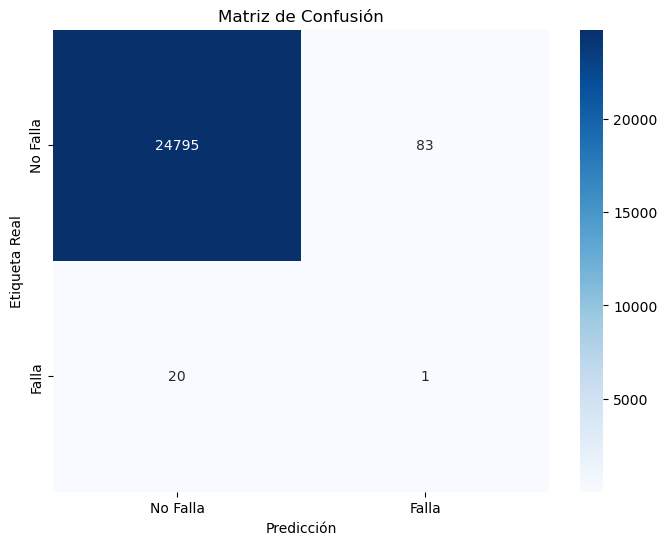

array([[24795,    83],
       [   20,     1]], dtype=int64)

In [35]:
graficar_confusion_matrix(y_test, y_test_pred)

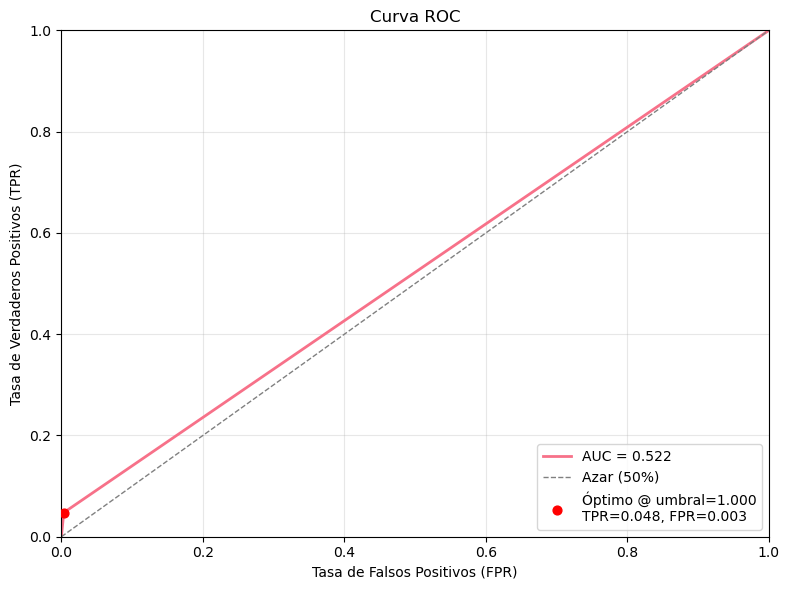

{'AUC': 0.522141383283758,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.047619047619047616,
 'FPR óptimo': 0.0033362810515314735}

In [36]:
graficar_roc_auc(y_test, y_test_pred)

<b> Pues que sigo con una AUC muy mala por cuenta de los parametros y del objetivo de optuna </b>